### 1. Input Energies in Hartree (Ha)

In [220]:
# Ground-state energies in Hartree (Ha)
energy = {
    'h2o': -74.816034,
    'so3': -613.795499,
    'h2so4': -688.199187
}

### 2. Compute Cluster Formation Energies (ΔE) in Hartree


In [221]:
# Cluster formation energies ΔE in Ha
deltaE_1 = energy['h2so4'] - (energy['so3'] + 1 * energy['h2o'])  # H2SO4 - (SO3 + H2O)
deltaE_2 = energy['h2so4'] - (energy['so3'] + 2 * energy['h2o'])  # H2SO4 - (SO3 + 2H2O)
deltaE_3 = energy['h2so4'] - (energy['so3'] + 3 * energy['h2o'])  # H2SO4 - (SO3 + 3H2O)

print(f"ΔE1: {deltaE_1} Ha, ΔE2: {deltaE_2} Ha, ΔE3: {deltaE_3} Ha")

ΔE1: 0.4123459999999568 Ha, ΔE2: 75.2283799999999 Ha, ΔE3: 150.04441399999985 Ha


### 3. Define Reaction Rate Function Based on Arrhenius Equation
Estimate how humidity affects reaction speed

Using Arrhenius equation:
$k(T)=A⋅e^{-E_a/RT}$

where:
$E_a≈\alpha ΔE$

$\alpha = 0.05^{n-1}$

T is temperature (assume ~298 K)

Vary relative humidity (RH) from 60% to 100%

In [222]:
# Convert ΔE to kJ/mol: 1 Hartree = 2625.5 kJ/mol
hartree_to_kjmol = 2625.5

cluster_energies_kjmol = {
    1: deltaE_1 * hartree_to_kjmol,
    2: 0.05*deltaE_2 * hartree_to_kjmol,
    3: (0.05**2)*deltaE_3 * hartree_to_kjmol
}

print(cluster_energies_kjmol)

{1: 1082.6144229998865, 2: 9875.605584499988, 3: 984.8540223924992}


In [223]:
import numpy as np
# compute rate for each cluster

R = 8.314  # J/mol·K
T = 313.15 #298    # K
A = 1e13   # s⁻¹, assumed pre-exponential factor

def arrhenius_rate(E_kjmol):
    E_Jmol = E_kjmol * 1000
    return A * np.exp(-E_Jmol / (R * T))

reaction_rates = {
    n: arrhenius_rate(E)
    for n, E in cluster_energies_kjmol.items()
}


In [224]:
reaction_rates

{1: np.float64(2.565513395759502e-168),
 2: np.float64(0.0),
 3: np.float64(5.206896310055212e-152)}

### 4. Compute Reaction Rates over RH Range
Link Rates to Relative Humidity (RH)

RH controls the concentration of H₂O vapor in the atmosphere. So we can model RH as influencing the probability of forming nH₂O clusters:

At low RH (60%), small clusters (n=1) are more likely.

At high RH (100%), larger clusters (n=3) dominate.

In [225]:
# Relative humidity values from 60% to 100%
rh_values = np.linspace(60, 100, 100)

# Weighting model: probability of cluster with n water molecules
def rh_weights(rh):
    """Return normalized weights for n=1,2,3 at a given RH (%)"""
    x = (rh - 60) / 40  # Normalize to [0,1]
    w1 = (1 - x)**2
    w2 = 2 * x * (1 - x)
    w3 = x**2
    total = w1 + w2 + w3
    return [w1/total, w2/total, w3/total]

we can use RH as a weighting factor:

$Rate_{total}=\sum_{n=1}^{3}𝑤_n(RH).k_n$

Where  $𝑤_𝑛$ is the likelihood of n H₂O molecules interacting at that RH.

In [226]:
total_rates = []

for rh in rh_values:
    w1, w2, w3 = rh_weights(rh)
    rate = (
        w1 * reaction_rates[1] +
        w2 * reaction_rates[2] +
        w3 * reaction_rates[3]
    )
    total_rates.append(rate)

### 5. Plot RH vs Predicted Nucleation Probability

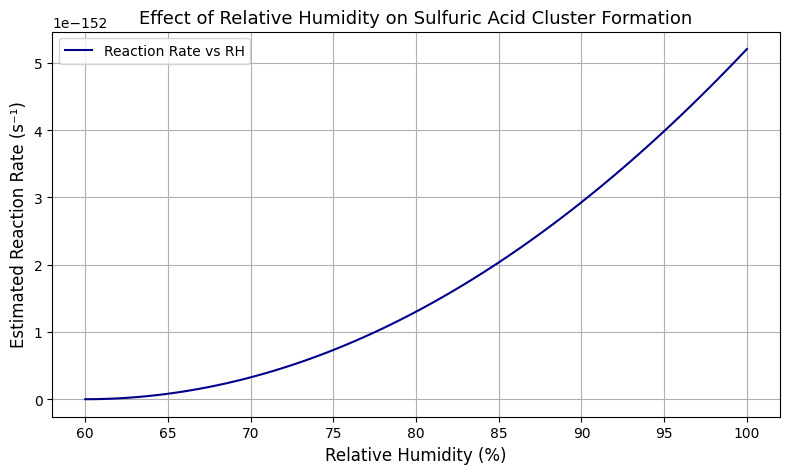

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(rh_values, total_rates, label="Reaction Rate vs RH", color='darkblue')
plt.xlabel("Relative Humidity (%)", fontsize=12)
plt.ylabel("Estimated Reaction Rate (s⁻¹)", fontsize=12)
plt.title("Effect of Relative Humidity on Sulfuric Acid Cluster Formation", fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()